# Exercise

* Link -> https://colab.research.google.com/github/mrdbourke/tensorflow-deep-learning/blob/main/10_time_series_forecasting_in_tensorflow.ipynb#scrollTo=PrLcCM-LFv2B

* Book -> https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#model-7-n-beats-algorithm

## Exercises

* LINK -> https://github.com/mrdbourke/tensorflow-deep-learning#-10-time-series-fundamentals-and-milestone-project-3-bitpredict--exercises

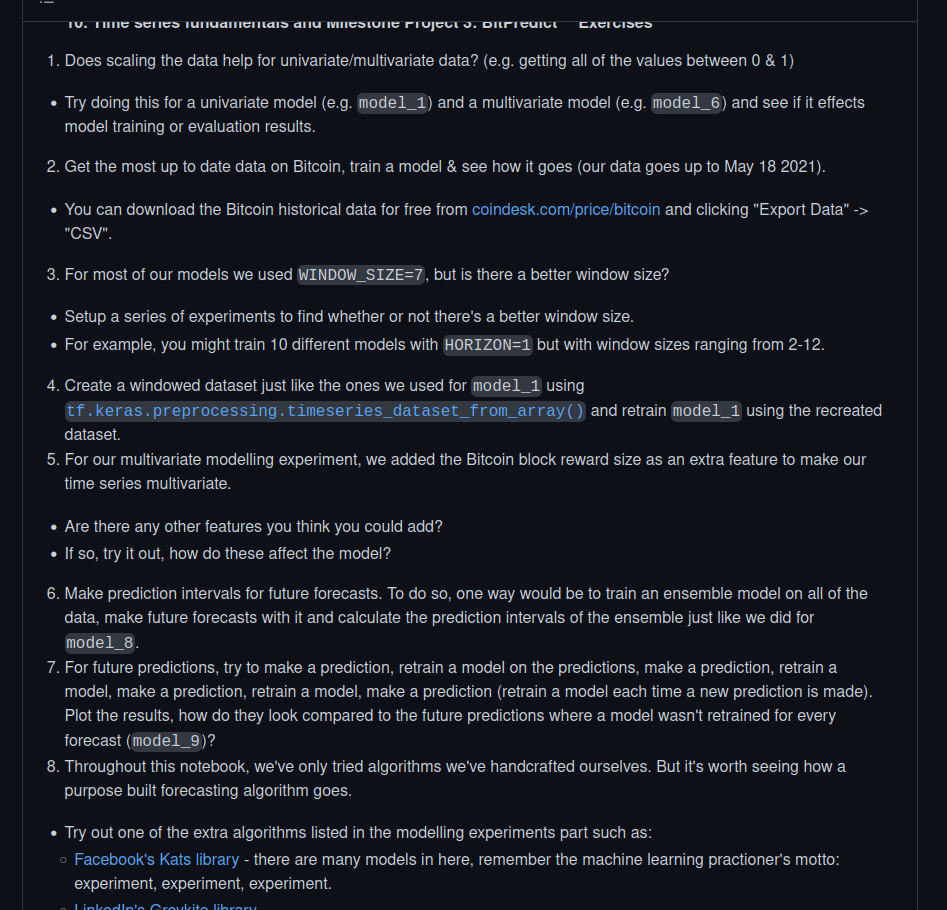

## Extra-curriculum


* Link ->  https://github.com/mrdbourke/tensorflow-deep-learning#-10-time-series-fundamentals-and-milestone-project-3-bitpredict--extra-curriculum

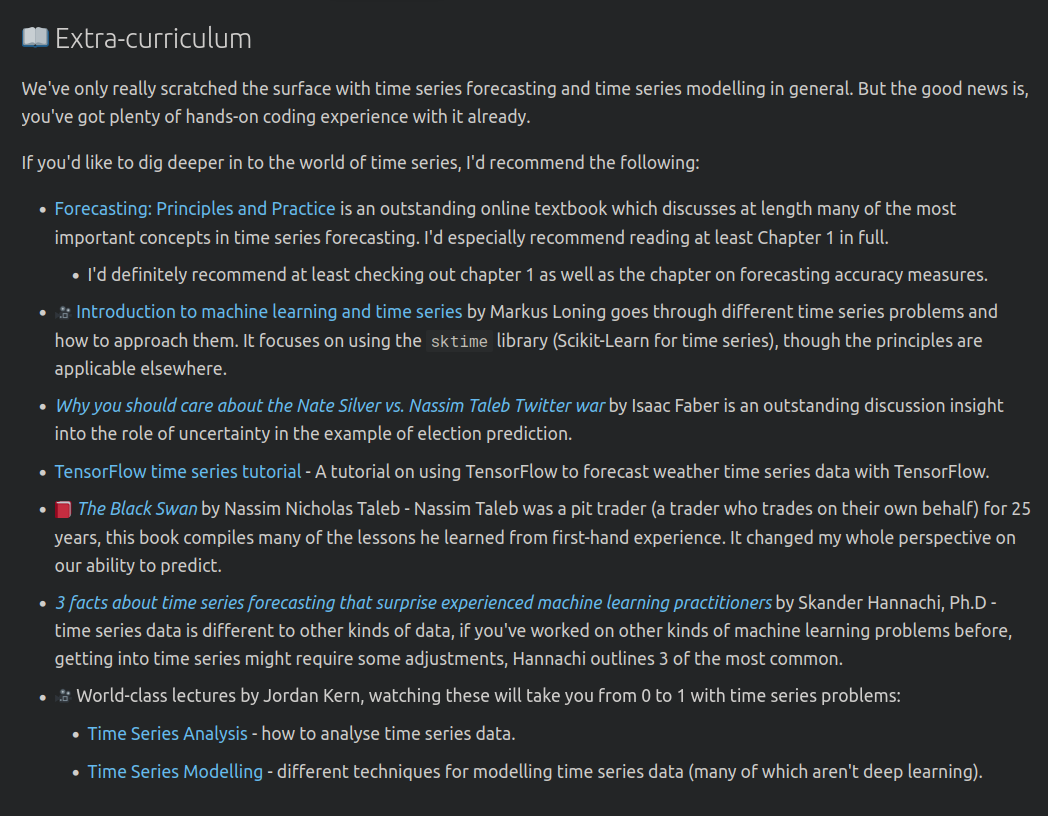

## Imports

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers

## `Exercise: 2` 

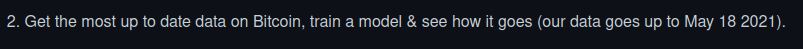

> This this already on when Learning about `Time Series Problems` notebook. I took the latest data from the 1st week of September to the beginning of 2013, where the prices of bitcoin were first recorded. 

* Link -> https://github.com/arghanath007/MachineLearning/blob/main/Time%20Series/Time_Series_Fundamentals_using_tensorflow.ipynb

## `Exercise: 3`

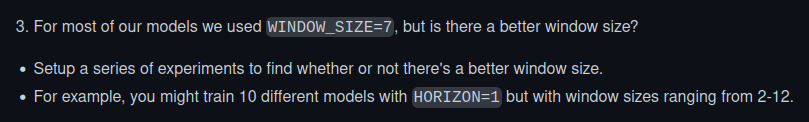

In [2]:
!wget https://raw.githubusercontent.com/arghanath007/MachineLearning/main/helper_functions.py

--2022-09-17 10:39:25--  https://raw.githubusercontent.com/arghanath007/MachineLearning/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30261 (30K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  29.55K  --.-KB/s    in 0.003s  

2022-09-17 10:39:25 (10.1 MB/s) - ‘helper_functions.py’ saved [30261/30261]



In [3]:
from helper_functions import model_check_point_callback, plot_loss_curves, create_early_stopping_callback, reduce_learning_rate_callback, model_check_point_callback, plot_time_series, make_train_test_split, make_windows, make_preds, evaluate_preds

### Data

In [4]:
!wget https://media.githubusercontent.com/media/arghanath007/MachineLearning/main/Time%20Series/BTC-USD.csv

--2022-09-17 10:39:26--  https://media.githubusercontent.com/media/arghanath007/MachineLearning/main/Time%20Series/BTC-USD.csv
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74121 (72K) [text/plain]
Saving to: ‘BTC-USD.csv’

BTC-USD.csv         100%[===================>]  72.38K  --.-KB/s    in 0.02s   

2022-09-17 10:39:26 (4.34 MB/s) - ‘BTC-USD.csv’ saved [74121/74121]



In [5]:
bitcoin_df= pd.read_csv('/content/BTC-USD.csv', parse_dates=["Date"], index_col=["Date"])
bitcoin_df.head()

,Close
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


## Constant Values

In [6]:
HORIZON=1
WINDOW_SIZE=30

In [7]:
bitcoin_df.head().index.to_numpy()

array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
       '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
       '2013-10-05T00:00:00.000000000'], dtype='datetime64[ns]')

In [8]:
bitcoin_df['Close'].head().to_numpy()

array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866])

In [9]:
timesteps= bitcoin_df.index.to_numpy()
prices= bitcoin_df['Close'].to_numpy()

timesteps[:5], prices[:5]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000'], dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866]))

## Making windows

In [10]:
full_windows, full_labels= make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3232, 3232)

In [11]:
train_windows, test_windows, train_labels, test_labels= make_train_test_split(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2585, 647, 2585, 647)

In [12]:
2585 + 647

3232

In [13]:
2609 + 653

3262

In [14]:
train_windows

array([[  123.65499 ,   125.455   ,   108.58483 , ...,   187.15983 ,
          192.75666 ,   197.4     ],
       [  125.455   ,   108.58483 ,   118.67466 , ...,   192.75666 ,
          197.4     ,   196.02499 ],
       [  108.58483 ,   118.67466 ,   121.33866 , ...,   197.4     ,
          196.02499 ,   198.04883 ],
       ...,
       [13075.248047, 13654.21875 , 13271.285156, ..., 18370.001953,
        18364.121094, 19107.464844],
       [13654.21875 , 13271.285156, 13437.882813, ..., 18364.121094,
        19107.464844, 18732.121094],
       [13271.285156, 13437.882813, 13546.522461, ..., 19107.464844,
        18732.121094, 17150.623047]])

## Converting the dataset 

In [15]:
np.asarray(train_windows).astype('float32')

array([[  123.65499,   125.455  ,   108.58483, ...,   187.15984,
          192.75665,   197.4    ],
       [  125.455  ,   108.58483,   118.67466, ...,   192.75665,
          197.4    ,   196.025  ],
       [  108.58483,   118.67466,   121.33866, ...,   197.4    ,
          196.025  ,   198.04883],
       ...,
       [13075.248  , 13654.219  , 13271.285  , ..., 18370.002  ,
        18364.121  , 19107.465  ],
       [13654.219  , 13271.285  , 13437.883  , ..., 18364.121  ,
        19107.465  , 18732.121  ],
       [13271.285  , 13437.883  , 13546.522  , ..., 19107.465  ,
        18732.121  , 17150.623  ]], dtype=float32)

In [16]:
train_windows= np.asarray(train_windows).astype('float32')
test_windows= np.asarray(train_windows).astype('float32')
train_labels= np.asarray(train_labels).astype('float32')
test_labels= np.asarray(test_labels).astype('float32')

In [17]:
tf.data.Dataset.from_tensor_slices(np.asarray(train_windows).astype('float32'))

<TensorSliceDataset element_spec=TensorSpec(shape=(30,), dtype=tf.float32, name=None)>

## Optimizing the datasets with the help of a function

In [18]:
def create_optimized_datasets(X_train, X_test, y_train, y_test, batch_size=1024):
  """
    Description:
      Function for Optimizing the datasets for improved and better performance. Model trains faster as well.
    Parameters: 
      X_train, X_test, y_train, y_test -> The datasets which need to be optimized.
    Return: 
      train_dataset, test_dataset
  """
  X_train= tf.data.Dataset.from_tensor_slices(X_train)
  y_train= tf.data.Dataset.from_tensor_slices(y_train)

  X_test= tf.data.Dataset.from_tensor_slices(X_test)
  y_test= tf.data.Dataset.from_tensor_slices(y_test)

  train_dataset= tf.data.Dataset.zip((X_train, y_train))
  test_dataset= tf.data.Dataset.zip((X_test, y_test))

  BATCH_SIZE= batch_size

  train_dataset= train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  test_dataset= test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

  return train_dataset, test_dataset

In [19]:
train_dataset, test_dataset= create_optimized_datasets(train_windows, test_windows, train_labels, test_labels)
train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 30), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 30), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>)

## Creating a multiple `Conv1D` model with different `WINDOW_SIZES` with the help of a function

In [20]:
def create_conv1d_models(window_size, horizon):
  """
    Description:  
      A function to create multiple CONV1D models with varying window_sizes and horizon to experiment and see which sizes work better or have better predictions

    Parameters:
      window_size= The window size we want to set for that particular model. It the no. of previous values the model will see to makes it prediction. Example: '7' means the model can look at the past '7' values and make a prediction by looking at them. 
      horizon= The horizon we want to set for that particular model. It is the no. for which the model will make predictions into the future. Example: '1' means the model can make a prediction '1' value into the future.
      model_count= The count of models we want.
    Returns:
     It return the model, we have to still fit the model on the dataset.
  """
  inputs= layers.Input(shape=(window_size, ), dtype="float32", name=f"model_inputs")
  expand_dims_layer= layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
  x= layers.Conv1D(filters= 128, kernel_size= window_size, padding="causal", activation="relu")(expand_dims_layer)
  x= layers.MaxPool1D(5, padding="same")(x)
  x= layers.Conv1D(filters= 128, kernel_size= window_size, padding="causal", activation="relu")(x)
  x= layers.MaxPool1D(5, padding="same")(x)
  outputs= layers.Dense(horizon, activation="linear", name=f"output_layer")(x)

  model= tf.keras.Model(inputs, outputs, name="model_conv1d")
  return model

In [21]:
WINDOW_SIZE, HORIZON

(30, 1)

## `Experiment 1:` Making the window size for 1month or 30days.

In [22]:
window_size= WINDOW_SIZE
horizon= HORIZON
model_30_1= create_conv1d_models(window_size, horizon)

In [23]:
model_30_1.summary()

Model: "model_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_inputs (InputLayer)   [(None, 30)]              0         
                                                                 
 lambda (Lambda)             (None, 1, 30)             0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            115328    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 128)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 128)            491648    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 128)           0         
 1D)                                                  

In [24]:
model_30_1.compile(loss="mae", optimizer= tf.keras.optimizers.Adam(), metrics=['mae', 'mse'])

history_model_30_1= model_30_1.fit(train_dataset, epochs=100, validation_data=test_dataset, callbacks=[model_check_point_callback('model_30_1','checkpoints', False, True, 'val_loss')])

Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 4032.6406 - mae: 4032.6406 - mse: 33354636.0000
Epoch 1: val_loss improved from inf to 40429.78125, saving model to checkpoints/model_30_1
3/3 [==============================] - 5s 2s/step - loss: 4032.6406 - mae: 4032.6406 - mse: 33354636.0000 - val_loss: 40429.7812 - val_mae: 40429.7812 - val_mse: 1789991936.0000
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 3523.1707 - mae: 3523.1707 - mse: 25548538.0000
Epoch 2: val_loss improved from 40429.78125 to 40363.70312, saving model to checkpoints/model_30_1
3/3 [==============================] - 4s 2s/step - loss: 3523.1707 - mae: 3523.1707 - mse: 25548538.0000 - val_loss: 40363.7031 - val_mae: 40363.7031 - val_mse: 1784317952.0000
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 2755.0649 - mae: 2755.0649 - mse: 15691895.0000
Epoch 3: val_loss improved from 40363.70312 to 40257.01172, saving model to checkpoints/model_30_1
3/3 [=====

In [25]:
model_30_1.evaluate(test_dataset)

1/1 [==============================] - 0s 34ms/step - loss: 40028.8633 - mae: 40028.8633 - mse: 1756461184.0000


[40028.86328125, 40028.86328125, 1756461184.0]

In [26]:
model_30_1_checkpoint= tf.keras.models.load_model('/content/checkpoints/model_30_1')

In [27]:
model_30_1_checkpoint.evaluate(test_dataset)

1/1 [==============================] - 0s 180ms/step - loss: 39928.3789 - mae: 39928.3789 - mse: 1747164416.0000


[39928.37890625, 39928.37890625, 1747164416.0]

In [28]:
model_30_1_preds= make_preds(model_30_1_checkpoint, test_windows)
model_30_1_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([182.88922, 186.1304 , 189.17572, 193.08966, 196.19955],
      dtype=float32)>

In [29]:
test_labels.shape

(647, 1)

In [30]:
model_30_1_preds.shape

TensorShape([2585])

In [31]:
model_30_1_results= evaluate_preds(test_labels,model_30_1_preds)
model_30_1_results

{'mae': 35451.816,
 'mse': 1438814000.0,
 'rmse': 35882.137,
 'mape': 86.09022,
 'mase': 30.910671}

In [32]:
WINDOW_SIZE, HORIZON

(30, 1)

## `Experiment 2:` Making the window size for 2 Weeks or 14days.

In [33]:
WINDOW_SIZE= 14
HORIZON= 1
window_size= WINDOW_SIZE
horizon= HORIZON
model_14_1= create_conv1d_models(window_size, horizon)

In [34]:
model_14_1.summary()

Model: "model_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_inputs (InputLayer)   [(None, 14)]              0         
                                                                 
 lambda_1 (Lambda)           (None, 1, 14)             0         
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 128)            25216     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 1, 128)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 128)            229504    
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 1, 128)           0         
 1D)                                                  

In [35]:
full_windows, full_labels= make_windows(prices, window_size=window_size, horizon=horizon)
len(full_windows), len(full_labels)

(3248, 3248)

In [36]:
train_windows, test_windows, train_labels, test_labels= make_train_test_split(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2598, 650, 2598, 650)

In [37]:
train_dataset, test_dataset= create_optimized_datasets(train_windows, test_windows, train_labels, test_labels)
train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 14), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 14), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>)

In [38]:
model_14_1.compile(loss="mae", optimizer= tf.keras.optimizers.Adam(), metrics=['mae', 'mse'])

history_model_14_1= model_14_1.fit(train_dataset, epochs=100, validation_data=test_dataset, callbacks=[model_check_point_callback('model_14_1','checkpoints', False, True, 'val_loss')])

Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 3758.7605 - mae: 3758.7605 - mse: 29033368.0000
Epoch 1: val_loss improved from inf to 33413.03516, saving model to checkpoints/model_14_1
3/3 [==============================] - 3s 922ms/step - loss: 3758.7605 - mae: 3758.7605 - mse: 29033368.0000 - val_loss: 33413.0352 - val_mae: 33413.0352 - val_mse: 1227246976.0000
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 3123.5112 - mae: 3123.5112 - mse: 20077344.0000
Epoch 2: val_loss improved from 33413.03516 to 26509.04688, saving model to checkpoints/model_14_1
3/3 [==============================] - 2s 844ms/step - loss: 3123.5112 - mae: 3123.5112 - mse: 20077344.0000 - val_loss: 26509.0469 - val_mae: 26509.0469 - val_mse: 776153344.0000
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 2342.8606 - mae: 2342.8606 - mse: 11318421.0000
Epoch 3: val_loss improved from 26509.04688 to 17602.66602, saving model to checkpoints/model_14_1
3/3 [

In [39]:
model_14_1.evaluate(test_dataset)

1/1 [==============================] - 0s 28ms/step - loss: 1582.7681 - mae: 1582.7681 - mse: 4385316.0000


[1582.76806640625, 1582.76806640625, 4385316.0]

In [40]:
model_14_1_checkpoint= tf.keras.models.load_model('/content/checkpoints/model_14_1')

In [41]:
model_14_1_checkpoint.evaluate(test_dataset)

1/1 [==============================] - 0s 178ms/step - loss: 1582.7681 - mae: 1582.7681 - mse: 4385316.0000


[1582.76806640625, 1582.76806640625, 4385316.0]

In [42]:
model_14_1_preds=make_preds(model_14_1_checkpoint, test_windows)
model_14_1_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([18830.945, 18954.098, 18407.99 , 17966.475, 17986.506],
      dtype=float32)>

In [43]:
model_14_1_results= evaluate_preds(test_labels, model_14_1_preds)
model_14_1_results

{'mae': 14382.886,
 'mse': 314758980.0,
 'rmse': 17166.479,
 'mape': 41.542126,
 'mase': 12.560917}

In [44]:
model_30_1_results

{'mae': 35451.816,
 'mse': 1438814000.0,
 'rmse': 35882.137,
 'mape': 86.09022,
 'mase': 30.910671}

## `Experiment 3:` Making the window size for 3 Weeks or 21days.

In [45]:
WINDOW_SIZE= 21
HORIZON= 1
window_size= WINDOW_SIZE
horizon= HORIZON
model_21_1= create_conv1d_models(window_size, horizon)

In [46]:
model_21_1.summary()

Model: "model_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_inputs (InputLayer)   [(None, 21)]              0         
                                                                 
 lambda_2 (Lambda)           (None, 1, 21)             0         
                                                                 
 conv1d_4 (Conv1D)           (None, 1, 128)            56576     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 1, 128)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 1, 128)            344192    
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 1, 128)           0         
 1D)                                                  

In [47]:
full_windows, full_labels= make_windows(prices, window_size=window_size, horizon=horizon)
len(full_windows), len(full_labels)

(3241, 3241)

In [48]:
train_windows, test_windows, train_labels, test_labels= make_train_test_split(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2592, 649, 2592, 649)

In [49]:
train_dataset, test_dataset= create_optimized_datasets(train_windows, test_windows, train_labels, test_labels)
train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 21), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 21), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>)

In [50]:
model_21_1.compile(loss="mae", optimizer= tf.keras.optimizers.Adam(), metrics=['mae', 'mse'])

history_model_21_1= model_21_1.fit(train_dataset, epochs=100, validation_data=test_dataset, callbacks=[model_check_point_callback('model_21_1','checkpoints', False, True, 'val_loss')])

Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 4022.7075 - mae: 4022.7075 - mse: 33279412.0000
Epoch 1: val_loss improved from inf to 36619.07422, saving model to checkpoints/model_21_1
3/3 [==============================] - 4s 1s/step - loss: 4022.7075 - mae: 4022.7075 - mse: 33279412.0000 - val_loss: 36619.0742 - val_mae: 36619.0742 - val_mse: 1472409216.0000
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 3552.9382 - mae: 3552.9382 - mse: 26029224.0000
Epoch 2: val_loss improved from 36619.07422 to 31503.07227, saving model to checkpoints/model_21_1
3/3 [==============================] - 3s 1s/step - loss: 3552.9382 - mae: 3552.9382 - mse: 26029224.0000 - val_loss: 31503.0723 - val_mae: 31503.0723 - val_mse: 1093216000.0000
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 2936.1936 - mae: 2936.1936 - mse: 17786536.0000
Epoch 3: val_loss improved from 31503.07227 to 24117.11328, saving model to checkpoints/model_21_1
3/3 [=====

In [51]:
model_21_1.evaluate(test_dataset)

1/1 [==============================] - 0s 32ms/step - loss: 1825.7999 - mae: 1825.7999 - mse: 5902958.0000


[1825.7999267578125, 1825.7999267578125, 5902958.0]

In [52]:
model_21_1_checkpoint= tf.keras.models.load_model('/content/checkpoints/model_21_1')

In [53]:
model_21_1_preds=make_preds(model_21_1_checkpoint, test_windows)
model_21_1_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([18784.525, 18530.96 , 18317.545, 18206.38 , 18290.469],
      dtype=float32)>

In [54]:
model_21_1_results= evaluate_preds(test_labels, model_21_1_preds)
model_21_1_results

{'mae': 14355.48,
 'mse': 313490100.0,
 'rmse': 17129.975,
 'mape': 41.37362,
 'mase': 12.544361}

In [55]:
model_14_1_results

{'mae': 14382.886,
 'mse': 314758980.0,
 'rmse': 17166.479,
 'mape': 41.542126,
 'mase': 12.560917}

## `Experiment 4:` Making the window size for 4 Weeks or 28days.

In [56]:
WINDOW_SIZE= 28
HORIZON= 1
window_size= WINDOW_SIZE
horizon= HORIZON
model_28_1= create_conv1d_models(window_size, horizon)

In [57]:
model_28_1.summary()

Model: "model_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_inputs (InputLayer)   [(None, 28)]              0         
                                                                 
 lambda_3 (Lambda)           (None, 1, 28)             0         
                                                                 
 conv1d_6 (Conv1D)           (None, 1, 128)            100480    
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 1, 128)           0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 1, 128)            458880    
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 1, 128)           0         
 1D)                                                  

In [59]:
full_windows, full_labels= make_windows(prices, window_size, horizon)

In [60]:
train_windows, test_windows, train_labels, test_labels= make_train_test_split(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2587, 647, 2587, 647)

In [61]:
train_dataset, test_dataset= create_optimized_datasets(train_windows, test_windows, train_labels, test_labels)
train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 28), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 28), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>)

In [62]:
model_28_1.compile(loss="mae", optimizer= tf.keras.optimizers.Adam(), metrics=['mae', 'mse'])

history_model_28_1= model_28_1.fit(train_dataset, epochs=100, validation_data=test_dataset, callbacks=[model_check_point_callback('model_28_1','checkpoints', False, True, 'val_loss')])

Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 3983.2842 - mae: 3983.2842 - mse: 32581024.0000
Epoch 1: val_loss improved from inf to 35903.81641, saving model to checkpoints/model_28_1
3/3 [==============================] - 5s 1s/step - loss: 3983.2842 - mae: 3983.2842 - mse: 32581024.0000 - val_loss: 35903.8164 - val_mae: 35903.8164 - val_mse: 1415925888.0000
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 3434.4744 - mae: 3434.4744 - mse: 24293032.0000
Epoch 2: val_loss improved from 35903.81641 to 29172.67969, saving model to checkpoints/model_28_1
3/3 [==============================] - 6s 2s/step - loss: 3434.4744 - mae: 3434.4744 - mse: 24293032.0000 - val_loss: 29172.6797 - val_mae: 29172.6797 - val_mse: 941745024.0000
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 2602.0874 - mae: 2602.0874 - mse: 14051615.0000
Epoch 3: val_loss improved from 29172.67969 to 18977.31445, saving model to checkpoints/model_28_1
3/3 [======

In [63]:
model_28_1.evaluate(test_dataset)

1/1 [==============================] - 0s 41ms/step - loss: 1941.7474 - mae: 1941.7474 - mse: 6750340.0000


[1941.7474365234375, 1941.7474365234375, 6750340.0]

In [64]:
model_28_1_checkpoint= tf.keras.models.load_model('/content/checkpoints/model_28_1')

In [65]:
model_28_1_checkpoint.evaluate(test_dataset)

1/1 [==============================] - 0s 217ms/step - loss: 1941.7474 - mae: 1941.7474 - mse: 6750340.0000


[1941.7474365234375, 1941.7474365234375, 6750340.0]

In [66]:
model_28_1_preds=make_preds(model_28_1_checkpoint, test_windows)
model_28_1_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([18284.842, 18226.55 , 18353.697, 18690.467, 18713.771],
      dtype=float32)>

In [67]:
model_28_1_results= evaluate_preds(test_labels, model_28_1_preds)
model_28_1_results

{'mae': 14310.647,
 'mse': 311489500.0,
 'rmse': 17075.744,
 'mape': 41.06644,
 'mase': 12.477548}

In [68]:
model_21_1_results

{'mae': 14355.48,
 'mse': 313490100.0,
 'rmse': 17129.975,
 'mape': 41.37362,
 'mase': 12.544361}

In [69]:
model_14_1_results

{'mae': 14382.886,
 'mse': 314758980.0,
 'rmse': 17166.479,
 'mape': 41.542126,
 'mase': 12.560917}

In [70]:
model_30_1_results

{'mae': 35451.816,
 'mse': 1438814000.0,
 'rmse': 35882.137,
 'mape': 86.09022,
 'mase': 30.910671}

## `Experiment 5:` Making the window size for 29days.

In [71]:
WINDOW_SIZE= 29
HORIZON= 1
window_size= WINDOW_SIZE
horizon= HORIZON
model_29_1= create_conv1d_models(window_size, horizon)

In [72]:
model_29_1.summary()

Model: "model_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_inputs (InputLayer)   [(None, 29)]              0         
                                                                 
 lambda_4 (Lambda)           (None, 1, 29)             0         
                                                                 
 conv1d_8 (Conv1D)           (None, 1, 128)            107776    
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 1, 128)           0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 1, 128)            475264    
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 1, 128)           0         
 1D)                                                  

In [73]:
full_windows, full_labels= make_windows(prices, window_size, horizon)

In [74]:
train_windows, test_windows, train_labels, test_labels= make_train_test_split(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2586, 647, 2586, 647)

In [75]:
train_dataset, test_dataset= create_optimized_datasets(train_windows, test_windows, train_labels, test_labels)
train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 29), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 29), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>)

In [77]:
model_29_1.compile(loss="mae", optimizer= tf.keras.optimizers.Adam(), metrics=['mae', 'mse'])

history_model_29_1= model_29_1.fit(train_dataset, epochs=100, validation_data=test_dataset, callbacks=[model_check_point_callback('model_29_1','checkpoints', False, True, 'val_loss')])

Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 3673.5715 - mae: 3673.5715 - mse: 27691298.0000
Epoch 1: val_loss improved from inf to 31836.58789, saving model to checkpoints/model_29_1
3/3 [==============================] - 5s 1s/step - loss: 3673.5715 - mae: 3673.5715 - mse: 27691298.0000 - val_loss: 31836.5879 - val_mae: 31836.5879 - val_mse: 1117348736.0000
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 2909.6121 - mae: 2909.6121 - mse: 17464162.0000
Epoch 2: val_loss improved from 31836.58789 to 22460.95117, saving model to checkpoints/model_29_1
3/3 [==============================] - 4s 1s/step - loss: 2909.6121 - mae: 2909.6121 - mse: 17464162.0000 - val_loss: 22460.9512 - val_mae: 22460.9512 - val_mse: 567247360.0000
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 1765.8964 - mae: 1765.8964 - mse: 6706930.0000
Epoch 3: val_loss improved from 22460.95117 to 8733.81152, saving model to checkpoints/model_29_1
3/3 [========

In [79]:
model_29_1.evaluate(test_dataset)

1/1 [==============================] - 0s 41ms/step - loss: 1970.8431 - mae: 1970.8431 - mse: 6899078.0000


[1970.8431396484375, 1970.8431396484375, 6899078.0]

In [80]:
model_29_1_checkpoint= tf.keras.models.load_model('/content/checkpoints/model_29_1')

In [81]:
model_29_1_checkpoint.evaluate(test_dataset)

1/1 [==============================] - 0s 189ms/step - loss: 1970.8431 - mae: 1970.8431 - mse: 6899078.0000


[1970.8431396484375, 1970.8431396484375, 6899078.0]

In [82]:
model_29_1_preds=make_preds(model_29_1_checkpoint, test_windows)
model_29_1_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([18307.686, 18266.34 , 18282.967, 18607.477, 18719.434],
      dtype=float32)>

In [83]:
model_29_1_results= evaluate_preds(test_labels, model_29_1_preds)
model_29_1_results

{'mae': 14312.921,
 'mse': 311592580.0,
 'rmse': 17078.867,
 'mape': 41.084194,
 'mase': 12.479531}

In [84]:
model_28_1_results

{'mae': 14310.647,
 'mse': 311489500.0,
 'rmse': 17075.744,
 'mape': 41.06644,
 'mase': 12.477548}

In [85]:
model_21_1_results

{'mae': 14355.48,
 'mse': 313490100.0,
 'rmse': 17129.975,
 'mape': 41.37362,
 'mase': 12.544361}

In [86]:
model_14_1_results

{'mae': 14382.886,
 'mse': 314758980.0,
 'rmse': 17166.479,
 'mape': 41.542126,
 'mase': 12.560917}

In [87]:
model_30_1_results

{'mae': 35451.816,
 'mse': 1438814000.0,
 'rmse': 35882.137,
 'mape': 86.09022,
 'mase': 30.910671}

## `Experiment 6:` Making the window size for 31days.

In [88]:
WINDOW_SIZE= 31
HORIZON= 1
window_size= WINDOW_SIZE
horizon= HORIZON
model_31_1= create_conv1d_models(window_size, horizon)

In [89]:
model_31_1.summary()

Model: "model_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_inputs (InputLayer)   [(None, 31)]              0         
                                                                 
 lambda_5 (Lambda)           (None, 1, 31)             0         
                                                                 
 conv1d_10 (Conv1D)          (None, 1, 128)            123136    
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 1, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 1, 128)            508032    
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 1, 128)           0         
 g1D)                                                 

In [90]:
full_windows, full_labels= make_windows(prices, window_size, horizon)

In [91]:
train_windows, test_windows, train_labels, test_labels= make_train_test_split(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2584, 647, 2584, 647)

In [92]:
train_dataset, test_dataset= create_optimized_datasets(train_windows, test_windows, train_labels, test_labels)
train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 31), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 31), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>)

In [93]:
model_31_1.compile(loss="mae", optimizer= tf.keras.optimizers.Adam(), metrics=['mae', 'mse'])

history_model_31_1= model_31_1.fit(train_dataset, epochs=100, validation_data=test_dataset, callbacks=[model_check_point_callback('model_31_1','checkpoints', False, True, 'val_loss')])

Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 3886.0627 - mae: 3886.0627 - mse: 31012344.0000
Epoch 1: val_loss improved from inf to 34923.95703, saving model to checkpoints/model_31_1
3/3 [==============================] - 5s 1s/step - loss: 3886.0627 - mae: 3886.0627 - mse: 31012344.0000 - val_loss: 34923.9570 - val_mae: 34923.9570 - val_mse: 1340390784.0000
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 3309.4417 - mae: 3309.4417 - mse: 22519936.0000
Epoch 2: val_loss improved from 34923.95703 to 27349.35352, saving model to checkpoints/model_31_1
3/3 [==============================] - 4s 2s/step - loss: 3309.4417 - mae: 3309.4417 - mse: 22519936.0000 - val_loss: 27349.3535 - val_mae: 27349.3535 - val_mse: 830156928.0000
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 2345.1421 - mae: 2345.1421 - mse: 11449398.0000
Epoch 3: val_loss improved from 27349.35352 to 15278.76855, saving model to checkpoints/model_31_1
3/3 [======

In [94]:
model_31_1.evaluate(test_dataset)

1/1 [==============================] - 0s 48ms/step - loss: 1996.9517 - mae: 1996.9517 - mse: 7148404.0000


[1996.95166015625, 1996.95166015625, 7148404.0]

In [95]:
model_31_1_checkpoint= tf.keras.models.load_model('/content/checkpoints/model_31_1')

In [96]:
model_31_1_checkpoint.evaluate(test_dataset)

1/1 [==============================] - 0s 216ms/step - loss: 1996.9517 - mae: 1996.9517 - mse: 7148404.0000


[1996.95166015625, 1996.95166015625, 7148404.0]

In [97]:
model_31_1_preds=make_preds(model_31_1_checkpoint, test_windows)
model_31_1_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([18336.152, 18325.098, 18353.467, 18643.393, 18799.441],
      dtype=float32)>

In [98]:
model_31_1_results= evaluate_preds(test_labels, model_31_1_preds)
model_31_1_results

{'mae': 14315.75,
 'mse': 311702400.0,
 'rmse': 17082.396,
 'mape': 41.0752,
 'mase': 12.481996}

In [99]:
model_30_1_results

{'mae': 35451.816,
 'mse': 1438814000.0,
 'rmse': 35882.137,
 'mape': 86.09022,
 'mase': 30.910671}

In [100]:
model_29_1_results

{'mae': 14312.921,
 'mse': 311592580.0,
 'rmse': 17078.867,
 'mape': 41.084194,
 'mase': 12.479531}

In [101]:
model_28_1_results

{'mae': 14310.647,
 'mse': 311489500.0,
 'rmse': 17075.744,
 'mape': 41.06644,
 'mase': 12.477548}

In [102]:
model_21_1_results

{'mae': 14355.48,
 'mse': 313490100.0,
 'rmse': 17129.975,
 'mape': 41.37362,
 'mase': 12.544361}

In [103]:
model_14_1_results

{'mae': 14382.886,
 'mse': 314758980.0,
 'rmse': 17166.479,
 'mape': 41.542126,
 'mase': 12.560917}

## `Experiment 7:` Making the window size for 1day.

In [104]:
WINDOW_SIZE= 1
HORIZON= 1
window_size= WINDOW_SIZE
horizon= HORIZON
model_1_1= create_conv1d_models(window_size, horizon)

In [105]:
model_1_1.summary()

Model: "model_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_inputs (InputLayer)   [(None, 1)]               0         
                                                                 
 lambda_6 (Lambda)           (None, 1, 1)              0         
                                                                 
 conv1d_12 (Conv1D)          (None, 1, 128)            256       
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 1, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 1, 128)            16512     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 1, 128)           0         
 g1D)                                                 

In [106]:
full_windows, full_labels= make_windows(prices, window_size, horizon)

In [107]:
train_windows, test_windows, train_labels, test_labels= make_train_test_split(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2608, 653, 2608, 653)

In [108]:
train_dataset, test_dataset= create_optimized_datasets(train_windows, test_windows, train_labels, test_labels)
train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>)

In [109]:
model_1_1.compile(loss="mae", optimizer= tf.keras.optimizers.Adam(), metrics=['mae', 'mse'])

history_model_1_1= model_1_1.fit(train_dataset, epochs=100, validation_data=test_dataset, callbacks=[model_check_point_callback('model_1_1','checkpoints', False, True, 'val_loss')])

Epoch 1/100
1/3 [=========>....................] - ETA: 1s - loss: 335.1268 - mae: 335.1268 - mse: 133720.9688
Epoch 1: val_loss improved from inf to 26749.17578, saving model to checkpoints/model_1_1
3/3 [==============================] - 2s 773ms/step - loss: 2969.9077 - mae: 2969.9077 - mse: 18167974.0000 - val_loss: 26749.1758 - val_mae: 26749.1758 - val_mse: 786425728.0000
Epoch 2/100
1/3 [=========>....................] - ETA: 0s - loss: 282.2824 - mae: 282.2824 - mse: 94981.0469
Epoch 2: val_loss improved from 26749.17578 to 22537.32422, saving model to checkpoints/model_1_1
3/3 [==============================] - 1s 545ms/step - loss: 2527.3257 - mae: 2527.3257 - mse: 13175722.0000 - val_loss: 22537.3242 - val_mae: 22537.3242 - val_mse: 558782400.0000
Epoch 3/100
1/3 [=========>....................] - ETA: 0s - loss: 237.8757 - mae: 237.8757 - mse: 67566.6406
Epoch 3: val_loss improved from 22537.32422 to 18307.54883, saving model to checkpoints/model_1_1
3/3 [==================

In [110]:
model_1_1.evaluate(test_dataset)

1/1 [==============================] - 0s 23ms/step - loss: 1141.5079 - mae: 1141.5079 - mse: 2596624.5000


[1141.5079345703125, 1141.5079345703125, 2596624.5]

In [111]:
model_1_1_checkpoint= tf.keras.models.load_model('/content/checkpoints/model_1_1')

In [113]:
model_1_1_checkpoint.evaluate(test_dataset)

1/1 [==============================] - 0s 179ms/step - loss: 1140.0675 - mae: 1140.0675 - mse: 2588255.0000


[1140.0675048828125, 1140.0675048828125, 2588255.0]

In [115]:
model_1_1_preds=make_preds(model_1_1_checkpoint, test_windows)
model_1_1_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([18632.527, 18360.443, 18354.564, 19097.51 , 18722.367],
      dtype=float32)>

In [116]:
model_1_1_results= evaluate_preds(test_labels, model_1_1_preds)
model_1_1_results

{'mae': 14443.604,
 'mse': 317433440.0,
 'rmse': 17241.727,
 'mape': 41.87575,
 'mase': 12.653104}

In [117]:
model_31_1_results

{'mae': 14315.75,
 'mse': 311702400.0,
 'rmse': 17082.396,
 'mape': 41.0752,
 'mase': 12.481996}

In [118]:
model_30_1_results

{'mae': 35451.816,
 'mse': 1438814000.0,
 'rmse': 35882.137,
 'mape': 86.09022,
 'mase': 30.910671}

In [119]:
model_29_1_results

{'mae': 14312.921,
 'mse': 311592580.0,
 'rmse': 17078.867,
 'mape': 41.084194,
 'mase': 12.479531}

In [120]:
model_28_1_results

{'mae': 14310.647,
 'mse': 311489500.0,
 'rmse': 17075.744,
 'mape': 41.06644,
 'mase': 12.477548}

In [122]:
model_21_1_results

{'mae': 14355.48,
 'mse': 313490100.0,
 'rmse': 17129.975,
 'mape': 41.37362,
 'mase': 12.544361}

In [123]:
model_14_1_results

{'mae': 14382.886,
 'mse': 314758980.0,
 'rmse': 17166.479,
 'mape': 41.542126,
 'mase': 12.560917}

## `Exercise: 4` 


* Link -> https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array

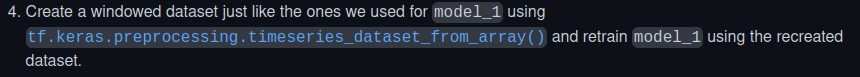

In [132]:
prices[:-10]

array([  123.65499 ,   125.455   ,   108.58483 , ..., 21395.019531,
       21600.904297, 20260.019531])

In [133]:
prices[10:]

array([  125.27966 ,   125.9275  ,   126.38333 , ..., 19832.087891,
       19986.712891, 19728.171875])

In [134]:
full_dataset= tf.keras.preprocessing.timeseries_dataset_from_array(prices[:-60], prices[1:], sequence_length=10)
full_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [125]:
len(full_dataset)

26

In [126]:
for batch in full_dataset:
  inputs, targets = batch
  assert np.array_equal(inputs[0], prices[:10])  # First sequence: steps [0-9]
  assert np.array_equal(targets[0], prices[10])  # Corresponding target: step 10
  break


In [127]:
len(inputs)

128

In [128]:
len(targets)

128

In [129]:
batch[1]

<tf.Tensor: shape=(128,), dtype=float64, numpy=
array([ 125.27966,  125.9275 ,  126.38333,  135.24199,  133.20333,
        142.76333,  137.92333,  142.95166,  152.55183,  160.33883,
        164.31499,  177.63333,  188.29716,  200.70166,  180.355  ,
        175.03166,  177.6965 ,  187.15983,  192.75666,  197.4    ,
        196.02499,  198.04883,  198.93233,  200.543  ,  210.3075 ,
        225.02   ,  248.25333,  262.32666,  294.48699,  331.10325,
        285.8875 ,  304.97974,  338.137  ,  357.48   ,  402.954  ,
        409.10375,  420.21649,  437.29725,  510.6025 ,  693.65   ,
        531.54249,  574.71599,  681.33   ,  774.18   ,  746.19374,
        768.8475 ,  789.36475,  893.1815 ,  934.355  , 1068.363  ,
       1154.92593, 1099.51926, 1019.78966, 1028.845  , 1071.2848 ,
       1139.33083, 1004.61633,  759.43041,  689.81   ,  841.83966,
        916.77599,  967.42866,  866.29003,  911.23204,  889.81946,
        848.9975 ,  868.95316,  653.80483,  654.06266,  553.69166,
        693.05

In [130]:
inputs[:-1]

<tf.Tensor: shape=(127, 10), dtype=float64, numpy=
array([[123.65499, 125.455  , 108.58483, ..., 123.033  , 124.049  ,
        125.96116],
       [125.455  , 108.58483, 118.67466, ..., 124.049  , 125.96116,
        125.27966],
       [108.58483, 118.67466, 121.33866, ..., 125.96116, 125.27966,
        125.9275 ],
       ...,
       [854.7225 , 856.03366, 847.70697, ..., 668.86463, 700.44843,
        694.3125 ],
       [856.03366, 847.70697, 844.28836, ..., 700.44843, 694.3125 ,
        665.7975 ],
       [847.70697, 844.28836, 802.75333, ..., 694.3125 , 665.7975 ,
        645.615  ]])>

In [136]:
WINDOW_SIZE= 60
HORIZON= 1
window_size= WINDOW_SIZE
horizon= HORIZON
model_60_1= create_conv1d_models(window_size, horizon)

In [137]:
model_60_1.summary()

Model: "model_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_inputs (InputLayer)   [(None, 60)]              0         
                                                                 
 lambda_8 (Lambda)           (None, 1, 60)             0         
                                                                 
 conv1d_16 (Conv1D)          (None, 1, 128)            460928    
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 1, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_17 (Conv1D)          (None, 1, 128)            983168    
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 1, 128)           0         
 g1D)                                                 

In [138]:
# model_60_1.compile(loss="mae", optimizer= tf.keras.optimizers.Adam(), metrics=['mae', 'mse'])

# history_model_60_1= model_60_1.fit(train_dataset, epochs=100, callbacks=[model_check_point_callback('model_60_1','checkpoints', False, True, 'val_loss')])

Epoch 1/100


ValueError: ignored

## `Exercise: 7` 

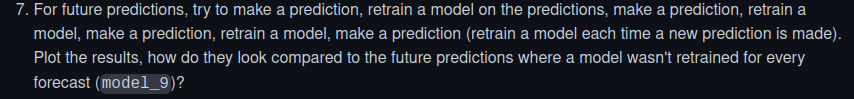